In [1]:
# Import the dependencies
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func

In [2]:
# Create engine using the `earthquakes.sqlite` database file
engine = create_engine("sqlite:///mlb_dataset.sqlite")

In [3]:
 # Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

mlb_dataset
--------
year BIGINT
player_name TEXT
player_position TEXT
team TEXT
team_abv TEXT
latitude FLOAT
longitude FLOAT
G BIGINT
AB BIGINT
R BIGINT
H BIGINT
2B BIGINT
3B BIGINT
HR BIGINT
RBI BIGINT
BB BIGINT
SO BIGINT
SB BIGINT
CS BIGINT
AVG FLOAT
OBP FLOAT
SLG FLOAT
OPS FLOAT
league TEXT
division TEXT



In [4]:
conn = engine.connect()

In [5]:
# Raw SQL
query = text("""SELECT
                    year,
                    team_abv,
                    SUM(HR) AS total_home_runs
                FROM
                    mlb_dataset
                GROUP BY
                    year, team_abv
                ORDER BY
                    year ASC, total_home_runs ASC;""")
df1 = pd.read_sql(query, con=conn)
df1 = pd.read_sql(query, con=conn)
df1.head(10)

,year,team_abv,total_home_runs
0,2019,DET,36
1,2019,TOR,138
2,2019,MIA,141
3,2019,SD,162
4,2019,SEA,171
5,2019,SF,207
6,2019,TB,282
7,2019,TEX,282
8,2019,CIN,294
9,2019,BAL,306


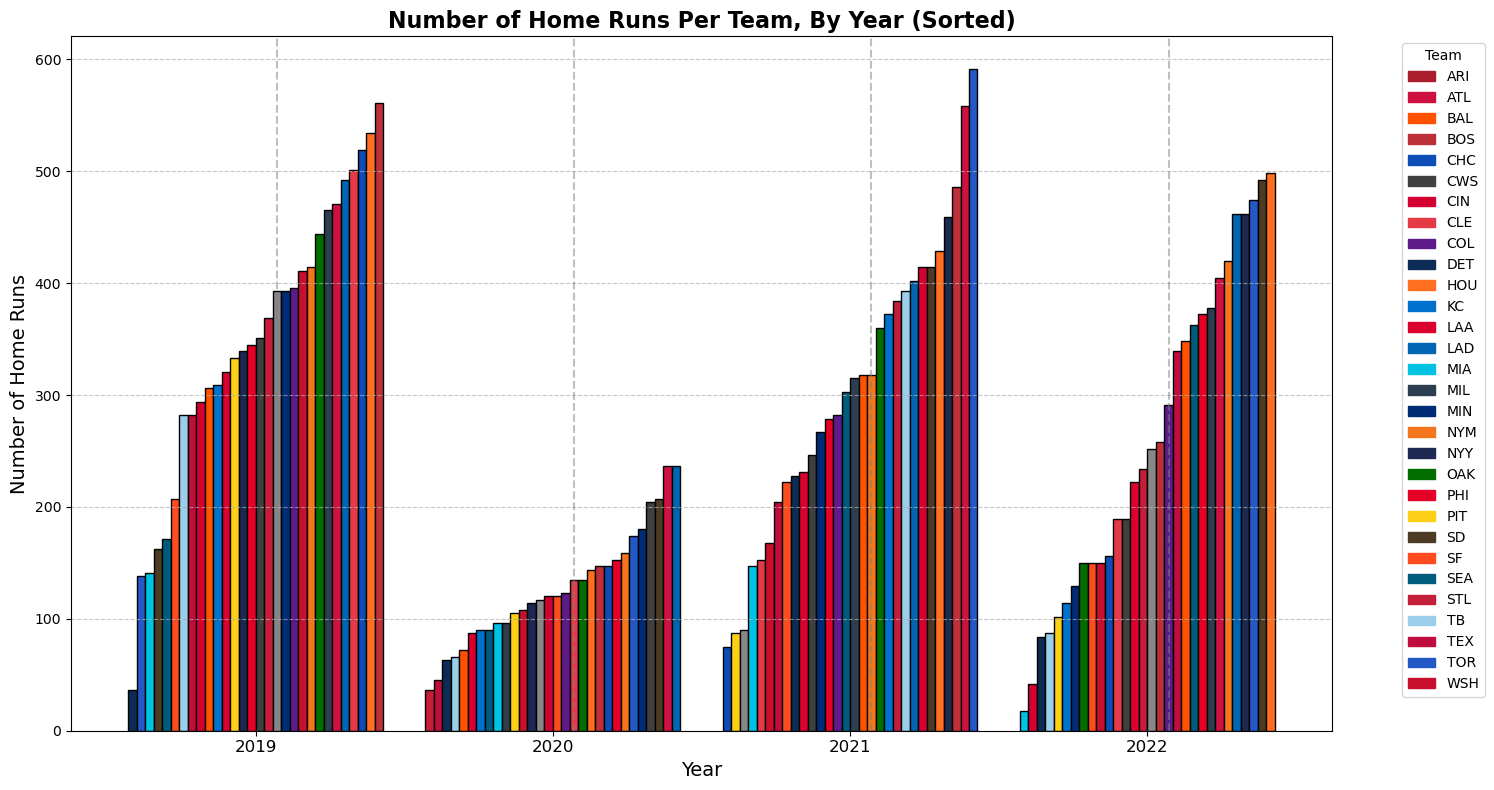

In [6]:
# Grouped Bar Chart

# Define team colors
team_colors = {
    "ARI": "#A91D2D", "ATL": "#CE1141", "BAL": "#FF5100", "BOS": "#BD3039", "CHC": "#0E4CB6",
    "CWS": "#404040", "CIN": "#D50032", "CLE": "#E63946", "COL": "#5E1C8A", "DET": "#0C2C56",
    "HOU": "#FF6F1F", "KC": "#0072CE", "LAA": "#DC002E", "LAD": "#0066B3", "MIA": "#00C3E3",
    "MIL": "#2C3E50", "MIN": "#002B75", "NYM": "#F5751D", "NYY": "#1D2951", "OAK": "#026E00",
    "PHI": "#E60026", "PIT": "#FDD017", "SD": "#4D3B24", "SF": "#FE4C1E", "SEA": "#005C7C",
    "STL": "#C41E3A", "TB": "#9ACEEB", "TEX": "#BF0D3E", "TOR": "#2359C7", "WSH": "#C8102E"
}

# Extract unique years
years = df1["year"].unique()
years.sort()

# Sort
df1 = df1.sort_values(by=["year", "total_home_runs"], ascending=[True, True])

# Width and spacing
bar_width = 1
group_spacing = 5

# Calculate x-axis positions
x_positions = []
year_centers = {}
current_pos = 0

for year in years:
    df_year = df1[df1["year"] == year]
    
    # Generate x positions for each team
    year_positions = list(range(current_pos, current_pos + len(df_year)))
    x_positions.extend(year_positions)
    
    # Store the center position of each year
    year_centers[year] = (year_positions[0] + year_positions[-1]) / 2
    
    # Update position for next group
    current_pos += len(df_year) + group_spacing

# Colors
bar_colors = [team_colors.get(team, "#888888") for team in df1["team_abv"]]

# Create chart
plt.figure(figsize=(15, 8))
plt.bar(
    x_positions,
    df1["total_home_runs"],
    color=bar_colors,
    edgecolor="black",
    width=bar_width
)

# Customize
plt.title("Number of Home Runs Per Team, By Year (Sorted)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Home Runs", fontsize=14)

# Set x-axis labels
plt.xticks(list(year_centers.values()), labels=years, fontsize=12)

# Add vertical separators
for pos in year_centers.values():
    plt.axvline(x=pos + (group_spacing / 2), color="gray", linestyle="--", alpha=0.5)

# Create legend
handles = [plt.Rectangle((0, 0), 1, 1, color=team_colors[team]) for team in team_colors]
plt.legend(handles, team_colors.keys(), title="Team", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# Viz
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
#Total Home Runs for full period
# Raw SQL for cumulative total HRs per team
query = text("""SELECT
                    team_abv,
                    SUM(HR) AS total_home_runs
                FROM
                    mlb_dataset
                GROUP BY
                    team_abv
                ORDER BY
                    total_home_runs DESC;""")  # Order by most HRs

# Execute query and load into DataFrame
df_cumulative = pd.read_sql(query, con=conn)
df_cumulative.head(10)

,team_abv,total_home_runs
0,ATL,1671
1,HOU,1605
2,LAD,1593
3,BOS,1452
4,TOR,1377
5,NYY,1374
6,NYM,1311
7,SD,1275
8,MIL,1254
9,PHI,1149


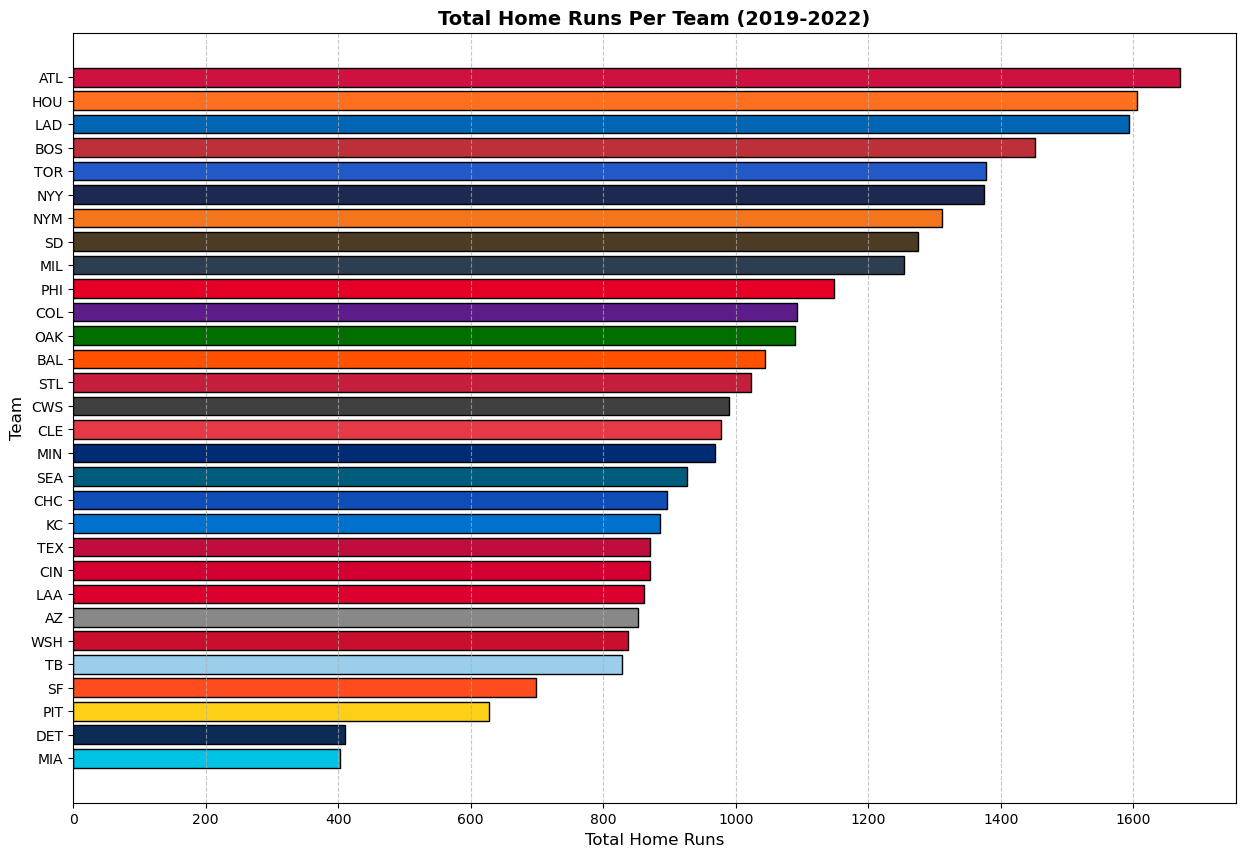

In [8]:
# Total home runs for each team across all years
df3 = df1.groupby("team_abv")["total_home_runs"].sum().reset_index()

# Sort teams
df3 = df3.sort_values(by="total_home_runs", ascending=True)

# Set figure size
plt.figure(figsize=(15, 10))

# Plot barh
plt.barh(df3["team_abv"], df3["total_home_runs"], 
         color=[team_colors.get(team, "#888888") for team in df3["team_abv"]], edgecolor="black")

# Customize the chart
plt.title("Total Home Runs Per Team (2019-2022)", fontsize=14, fontweight="bold")
plt.xlabel("Total Home Runs", fontsize=12)
plt.ylabel("Team", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the chart
plt.show()

In [9]:
# Map Data

In [10]:
# Raw SQL
query = text("""SELECT
                    team_abv,
                    SUM(HR) AS total_home_runs,
                    latitude,
                    longitude
                FROM
                    mlb_dataset
                GROUP BY
                    team_abv, latitude, longitude
                ORDER BY
                    total_home_runs DESC;""")
df2 = pd.read_sql(query, con=conn)
df2.head(10)

,team_abv,total_home_runs,latitude,longitude
0,ATL,1671,33.890000,-84.468000
1,HOU,1605,29.756944,-95.355556
2,LAD,1593,34.073611,-118.240000
3,BOS,1452,42.346250,-71.097750
4,TOR,1377,43.641389,-79.389167
5,NYY,1374,40.829167,-73.926389
6,NYM,1311,40.756944,-73.845833
7,SD,1275,32.707300,-117.156600
8,MIL,1254,43.028333,-87.971111
9,PHI,1149,39.905833,-75.166389


In [11]:
conn.close()
engine.dispose()